# Heuristicas

In [1]:
import utils
import random

import simulator as sim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm import trange
from typing import List


DATA = "../data/sim.dat"
POWERS = "../data/sim_powers.tsv"

In [2]:
def read_powers() -> pd.DataFrame:
    return pd.read_csv(
        POWERS,
        sep=' ',
        header=None,
        names=["team", "power"],
    )

def read_sim_ranking(path: str):
    powers = read_powers()
    ranking = utils.read_ranking(path)
    ranking["power"] = (ranking.index + 1).map(powers.set_index("team")["power"])
    ranking["team"] = (ranking.index+1)
    return ranking

def randseed() -> int:
    return random.randint(1, 10000)

In [3]:
# Cambiar esta linea para que los experimentos sean reproducibles
#initial_seed = randseed()
initial_seed = 6884
print("Using seed:", initial_seed)
random.seed(initial_seed)

Using seed: 6884


In [4]:
import lose_heuristic as heur
import HillClimberHeuristic as hill
import min_cmm

# iterar e imprimir boxplot
TEAM_COUNT = 10
SELECTED = 8
ITER = 50
GOALS = 9
POWER_TYPE = "linear" # "exponential"

heuristics = [
    { "name": "lose_better",   "fn": heur.lose_better       },
    { "name": "lose_worse",    "fn": heur.lose_worse        },
    { "name": "win_one",       "fn": heur.win_one           },
    { "name": "hill_climber",  "fn": hill.HillClimber       },
    { "name": "none",          "fn": None                   },
    { "name": "min_cmm",       "fn": min_cmm.min_cmm        },
    { "name": "min_cmm_tol_1", "fn": min_cmm.min_cmm_tol_1  },
    { "name": "min_cmm_tol_3", "fn": min_cmm.min_cmm_tol_3  },
]

DATA_FMT = "../data/sim.{}.dat"
RANKING_FMT = DATA_FMT+utils.OUT

results = pd.DataFrame(columns=["rating", "ranking", "wins", "heuristic"])

for i in tqdm(range(ITER)):
    seed = randseed()
    for h in heuristics:
        data = DATA_FMT.format(h["name"])
        ranks = RANKING_FMT.format(h["name"])
        fn = h["fn"]

        # perform the simulation
        sim.simulate(
            team_count=TEAM_COUNT,
            heuristic=fn,
            selected=SELECTED,
            goals_per_game=GOALS,
            matches_output=data,
            seed=seed,
            powers=POWER_TYPE,
        )

        # create the ranking
        utils.run(data, utils.METHOD_CMM, ranks)

        # read the ranking & analyze the data
        ranking = read_sim_ranking(ranks)
        analyzed_data = utils.analyze_data(data)
        srt = ranking.sort_values("rating", ascending=False).reset_index()
        results = results.append({
            "rating": ranking.set_index("team").at[SELECTED, "rating"],
            "ranking": srt[srt["team"] == SELECTED].index[0] + 1,
            "wins": analyzed_data.set_index("team").loc[SELECTED].values[2],
            "heuristic": h["name"]
        }, ignore_index=True)

print("Done!")

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]

Done!


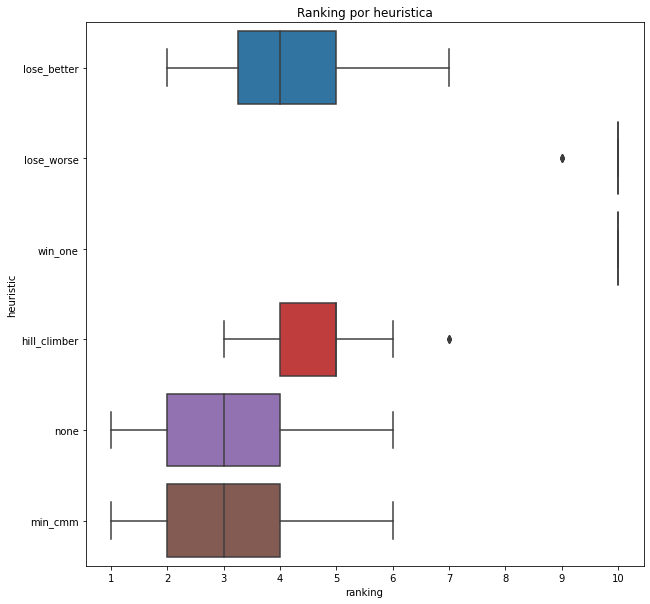

In [5]:
# todos
plt.subplots(1, 1, figsize=(10, 10))
plot = sns.boxplot(
    data=results.query(
        "heuristic != 'min_cmm_tol_1' &"+
        "heuristic != 'min_cmm_tol_3'"
    ),
    x="ranking", 
    y="heuristic"
)
plot.set_title("Ranking por heuristica")
plot.set_xticks(range(1, TEAM_COUNT+1))
plot

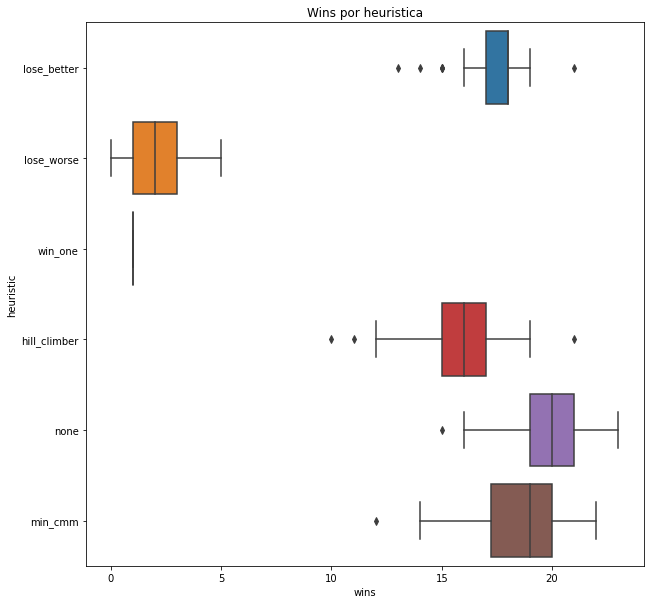

In [6]:
plt.subplots(1, 1, figsize=(10, 10))
plot = sns.boxplot(
    data=results.query(
        "heuristic != 'min_cmm_tol_1' &"+
        "heuristic != 'min_cmm_tol_3'"
    ),
    x="wins", 
    y="heuristic"
).set_title("Wins por heuristica")

In [7]:
# concluimos que min_cmm es la mejor

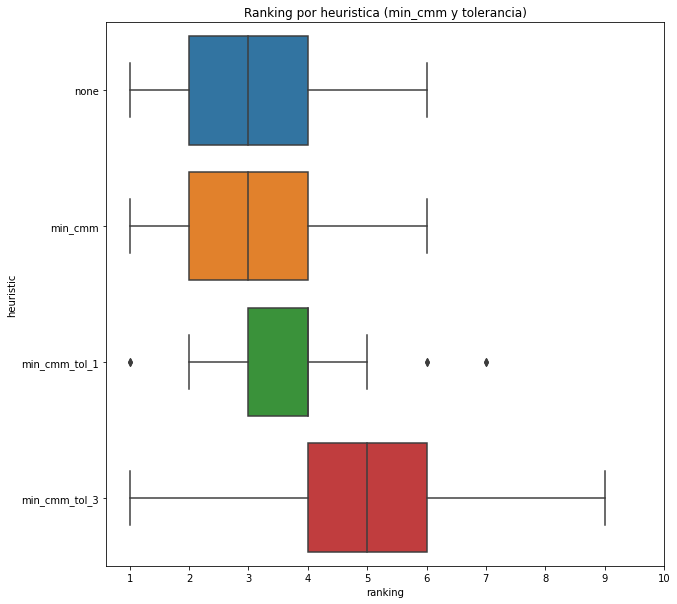

In [8]:
# presentamos alternativas
plt.subplots(1, 1, figsize=(10, 10))
plot = sns.boxplot(
    data=results.query(
        "heuristic == 'none' |" +
        "heuristic == 'min_cmm' |" +
        "heuristic == 'min_cmm_tol_1' |" +
        "heuristic == 'min_cmm_tol_3'"

    ),
    x="ranking", 
    y="heuristic"
)
plot.set_title("Ranking por heuristica (min_cmm y tolerancia)")
plot.set_xticks(range(1, TEAM_COUNT+1))
plot

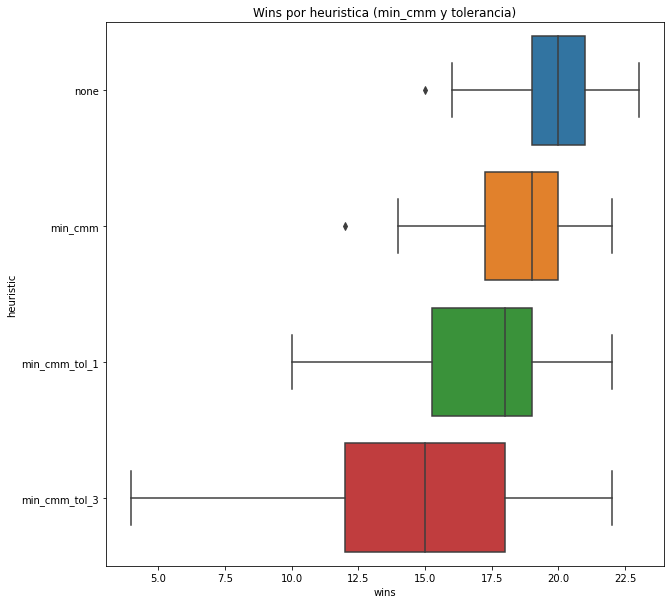

In [9]:
plt.subplots(1, 1, figsize=(10, 10))
plot = sns.boxplot(
    data=results.query(
        "heuristic == 'none' |" +
        "heuristic == 'min_cmm' |" +
        "heuristic == 'min_cmm_tol_1' |" +
        "heuristic == 'min_cmm_tol_3'"

    ),
    x="wins", 
    y="heuristic"
)
plot.set_title("Wins por heuristica (min_cmm y tolerancia)")
plot

In [10]:
def rank_progressively(
        weeks: int, # cantidad de semanas
        teams: int, # cantidad de equipos
        seed: int,  # seed del simulador
        heuristic=None,
    ) -> pd.DataFrame:
    
    path = DATA
    # Genero todos los datos
    sim.simulate(
        weeks=weeks,
        team_count=teams,
        heuristic=heuristic,
        selected=SELECTED,
        goals_per_game=GOALS,
        matches_output=path,
        seed=seed,
    )
    
    data = utils.read_mn(path).set_index("date")
    ratings_by_week = pd.DataFrame()

    for week in tqdm(range(1, weeks+1)):
        data_til_week = path + f".week{week}"
        spliced = data.loc[:week]
    
        # Escribo el header con cant equipos y games
        with open(data_til_week, "w") as f:
            print(f"{teams} {spliced.shape[0]}", file=f)

        spliced.to_csv(data_til_week, sep=" ", mode="a", header=False)

        utils.run(data_til_week, utils.METHOD_CMM)
        ranking = read_sim_ranking(data_til_week+utils.METHOD_CMM+utils.OUT)
        ranking["week"] = week
        ratings_by_week = ratings_by_week.append(ranking)

    return ratings_by_week


WEEKS = 20
seed = randseed()
normal = rank_progressively(WEEKS, TEAM_COUNT, seed=seed)
cmm = rank_progressively(WEEKS, TEAM_COUNT, heuristic=min_cmm.min_cmm, seed=seed)
cmm_1 = rank_progressively(WEEKS, TEAM_COUNT, heuristic=min_cmm.min_cmm_tol_1, seed=seed)
cmm_3 = rank_progressively(WEEKS, TEAM_COUNT, heuristic=min_cmm.min_cmm_tol_3, seed=seed)

print("Done!")

100%|██████████| 20/20 [00:00<00:00, 57.14it/s]

Done!


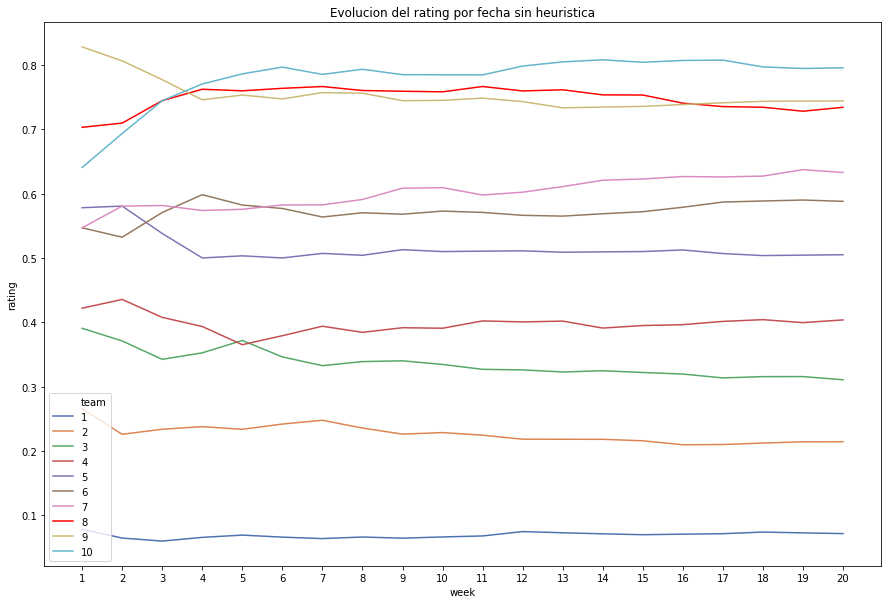

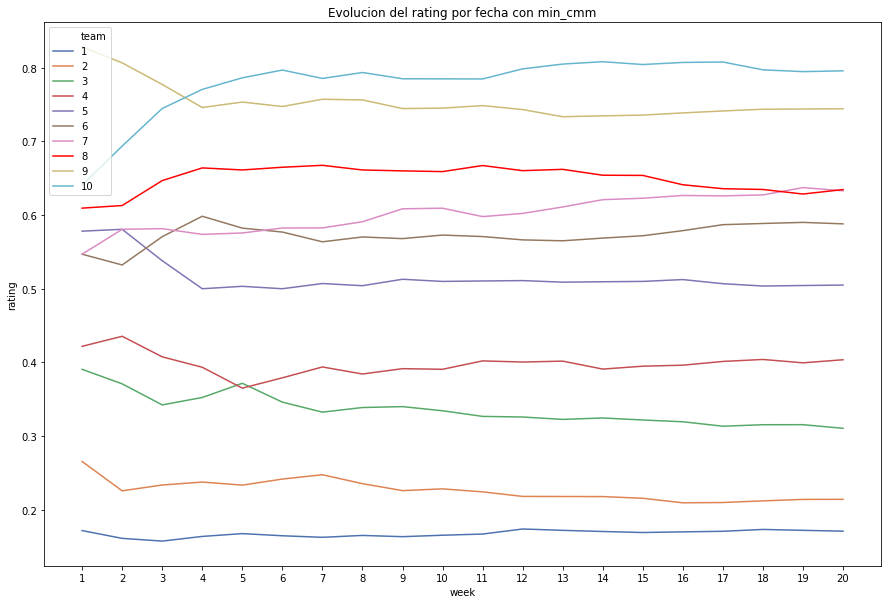

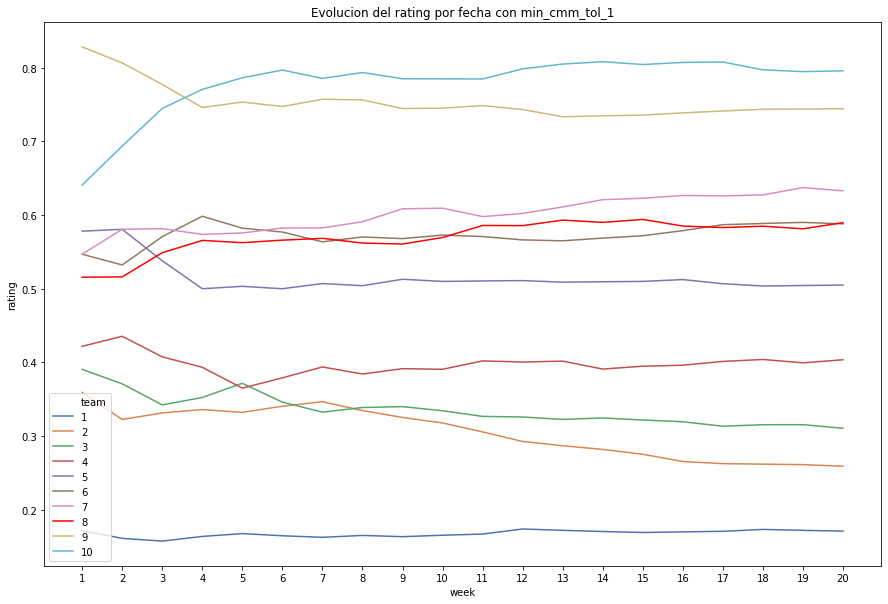

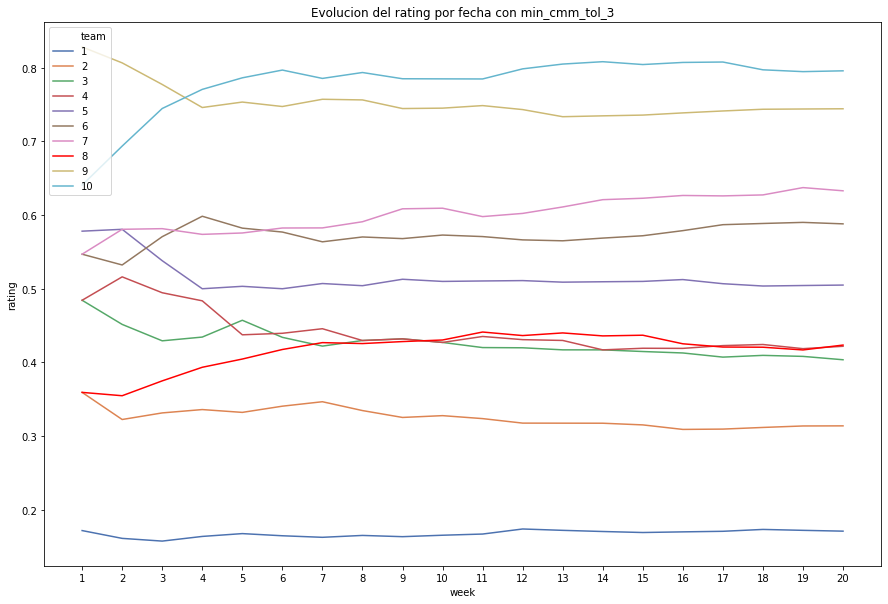

In [11]:
def plot_ratings_by_week(ratings: pd.DataFrame, name: str):
    fig, axs = plt.subplots(1, 1, figsize=(15, 10)) 
    palette = sns.color_palette("deep", TEAM_COUNT)
    palette[SELECTED-1] = "#ff0000"
    plot = sns.lineplot(
        data=ratings, 
        x="week", y="rating", 
        hue="team",
        markers=True,
        palette=palette,
        legend="full",
    )

    plot.set_title(f"Evolucion del rating por fecha {name}")
    plot.set_xticks(range(1, WEEKS + 1))

plot_ratings_by_week(normal, "sin heuristica")
plot_ratings_by_week(cmm, "con min_cmm")
plot_ratings_by_week(cmm_1, "con min_cmm_tol_1")
plot_ratings_by_week(cmm_3, "con min_cmm_tol_3")
